# Lab1886 Task
***

## Setting up

Before taking a first look at the data, I want to briefly comment on how I set up. I decided to use what I am most familiar with. In the context of ML, I therefore prefer to use *Anaconda* as a *Python* distribution, because it resolves issues connected to interdependencies and version compatibility between packages on its own. I choose *Keras* with *TensorFlow* as a backend as my framework as I am most familiar with them. For the most part I rely on *Pandas* and *pyplot* for data manipulation and visualization. 

I also set up a git repository on [bitbucket](https://bitbucket.org) for version control. On a general note, my preferred IDE for Python is PyCharm.

We use some standard built-in *magic* commands for jupyter notebooks

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import a few basic libraries ...

In [2]:
import os
import folium
import numpy as np
import pandas as pd
import pandas_summary as pdsm
from datetime import datetime
import seaborn as sbn
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import preprocessing

from model import *

from IPython.core.display import display, HTML

Using TensorFlow backend.


and set the path variable for our dataset

In [3]:
PATH = 'dataset/'

## The Task: Cycle Sharing in Seattle

In this task we are looking at a bicycle sharing system in Seattle. The [data](https://www.kaggle.com/pronto/cycle-share-dataset) provided by Pronto Cycle Share via kaggle provides data on individual trips, stations, and daily weather over a time span of approximately 2 years. 

**Goal.** We aim to predict the demand of bikes at a certain day, time, and station using a machine learning algorithm. 

## Creating DataFrames

The first step is to read-in the data. Each table is called by its file name. When I first ran the command 
I got a `ParseError` while processing *trip.csv*. Apperently, line 50794 exceeded the expected number of columns. Looking at that specific line, I saw the the head of the table as well as some other lines were repeated.

In [4]:
with open(f'{PATH}trip.csv', 'r') as file:
    for y in [x for i,x in enumerate(file) if i in [1, 2, 50793, 50793*2]]:
        print(y)

431,"10/13/2014 10:31","10/13/2014 10:48","SEA00298",985.935,"2nd Ave & Spring St","Occidental Park / Occidental Ave S & S Washington St","CBD-06","PS-04","Member","Male",1960

432,"10/13/2014 10:32","10/13/2014 10:48","SEA00195",926.375,"2nd Ave & Spring St","Occidental Park / Occidental Ave S & S Washington St","CBD-06","PS-04","Member","Male",1970

59000,"4/17/2015 14:21","4/17/2015 19:21","SEA00362",17990.668,"6th Ave S & S King St","Westlake Ave & 6th Ave","ID-04","SLU-15"trip_id","starttime","stoptime","bikeid","tripduration","from_station_name","to_station_name","from_station_id","to_station_id","usertype","gender","birthyear"

59000,"4/17/2015 14:21","4/17/2015 19:21","SEA00362",17990.668,"6th Ave S & S King St","Westlake Ave & 6th Ave","ID-04","SLU-15","Short-Term Pass Holder",,



I parsed *trip.csv* to a new file *new_trip.csv* and deleted the repeated header in line 50793 and processed the data into a `DataFrame`.

In [5]:
with open (f'{PATH}new_trip.csv', 'w') as new_file:
    with open(f'{PATH}trip.csv', 'r') as file:
        for i,line in enumerate(file):
            if i == 50793:
                new_file.write(line.split('trip_id',1)[0] + '\n')
            else: 
                new_file.write(line)

table_names = ['station', 'new_trip', 'weather']
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

To check for duplicates I looked at the summary, particularly for the trip_id, as this column should only have unique values.

In [6]:
pdsm.DataFrameSummary(tables[1][['trip_id']]).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
trip_id,286858,112432,76565.1,431,43051,103486,179545,255245,286858,236065,0,0%,numeric


This made me realize that the first 50793 lines were simply repeated as 
>`trip_id.counts - trip_id.uniques = 50793`.

I deleted the first entries in the *new_trip* table, reindexed the `DataFrame`, and quickly checked the dimensions match up as expected.

In [7]:
tables[1].drop(tables[1].index[:50793], inplace=True)
tables[1]=tables[1].reset_index(drop=True)
tables[1].shape

(236065, 12)

Saving what we have done so far so that we won't have to redo these steps.

In [8]:
for i,table in enumerate(tables):
    table.to_pickle(f'tmp/df{i}.pickle')

## First Look at the Data and Data-Cleaning

Aside from the imports and inlines at the beginning, we can now load the data directly into `DataFrames`. For now, we omit the weather data for simplification.

In [9]:
# Loading preprocessed tables into DataFrames
table_names = ['station', 'trip'] #, 'weather']
station, trip = [pd.read_pickle(f'tmp/df{i}.pickle') for i in range(len(table_names))]

At first, we take a look at the first few rows of both tables to get a first glimpse at the data. 

In [10]:
for table in [station, trip]: display(table.head(3))

,station_id,name,lat,long,install_date,install_dockcount,modification_date,current_dockcount,decommission_date
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18,NaN,18,NaN
1,BT-03,2nd Ave & Vine St,47.615829,-122.348564,10/13/2014,16,NaN,16,NaN
2,BT-04,6th Ave & Blanchard St,47.616094,-122.341102,10/13/2014,16,NaN,16,NaN


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0


We list the given categories and give a brief description of their meaning:
1. First table
    - `station_id` alphanumerical ID
    - `name` of station after nearby street name
    - `lat` latitude
    - `long` longitude
    - `install_date` since when is this station in business
    - `install_dockcount` how many docking station for a bike were there from day one
    - `modification_data` when was the dockcount updated in dockcount or location
    - `current_dockcount` max number of docking stations on 2016-08-31
    - `decommission_date` when was the station closed
2. Second table
    - `trip_id` unique numerical ID for a trip taken
    - `starttime` day and time trip started
    - `stoptime` day and time trip ended
    - `bike_id` unique alphanumerical ID for a bike
    - `trip_duration` duration of trip
    - `from_station_name` station trip started by name
    - `to_station_name` station trip ended by name
    - `from_station_id` station trip started by ID
    - `to_station_id` station trip ended by ID
    - `usertype` *Short-Term Pass Holder* is a rider who purchased a 24-Hour or 3-Day Pass; *Member* is a rider who purchased a Monthly or an Annual Membership
    - `gender` gender of rider
    - `birthyear` birth year of rider
    
In the first table we notice in `modification_date` and `decommission_date` already some missing values. The meanings of these variables also let's us suspect more missing values. We may also drop the `from_station_name` and `to_station_name` in the second table without risking loosing any information. 

In [11]:
trip = trip.drop(columns=['from_station_name', 'to_station_name'])

A summary of some statistical quantities is the second thing we want to take a look at. The main reason here is to get a better feeling for the condition the data is in, e.g., what type of data do we have (numerical, categorical, etc.) or are the missing values in specific columns.

In [12]:
for table in [station, trip]: display(pdsm.DataFrameSummary(table).summary().T)

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,58,0,0%,unique
name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,58,0,0%,unique
lat,58,47.6248,0.0190658,47.5985,47.6132,47.6186,47.6277,47.6661,58,58,0,0%,numeric
long,58,-122.327,0.0149567,-122.355,-122.339,-122.328,-122.317,-122.284,58,58,0,0%,numeric
install_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,9,0,0%,categorical
install_dockcount,58,17.5862,3.06099,12,16,18,18,30,58,7,0,0%,numeric
modification_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,12,41,70.69%,categorical
current_dockcount,58,16.5172,5.11702,0,16,18,18,26,58,7,0,0%,numeric
decommission_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,54,93.10%,unique


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
trip_id,236065,130060,72842.3,431,67746,130526,192900,255245,236065,236065,0,0%,numeric
starttime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,176216,0,0%,categorical
stoptime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,169285,0,0%,categorical
bikeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,493,0,0%,categorical
tripduration,236065,1202.61,2066.42,60.008,392.265,633.235,1145.02,28794.4,236065,218883,0,0%,numeric
from_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
to_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
usertype,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,2,0,0%,bool
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146171,3,89894,38.08%,categorical
birthyear,146167,1979.88,10.155,1931,1975,1983,1987,1999,146167,61,89898,38.08%,numeric


In the first table, we see missing values in the categories `modification_date` and `decommission_date`. Both categories either carry a date or no value. We plan to treat these variable as a categorical one and can therefore fill the NAs with a default date as a category, e.g. 1900-01-01. While we are at it we will also cast the dates and times into a `datetime` datatype.

In [13]:
# casting string to dtype datetime in both tables (This takes some time. About a minute ...)
for column in station.columns:
    if 'date' in column:
        station[column] = station[column].fillna('1900/01/01').astype(str)
        station[column] = pd.to_datetime(station[column])
        
for column in trip.columns:
    if 'time' in column:
        trip[column] = trip[column].fillna('1900/01/01').astype(str)
        trip[column] = pd.to_datetime(trip[column])

Taking a look at `gender` and `birthyear` in the *trip* table, we guess that for a specific trip either both values are known or none. We take a look at the missing values to question our intuition.

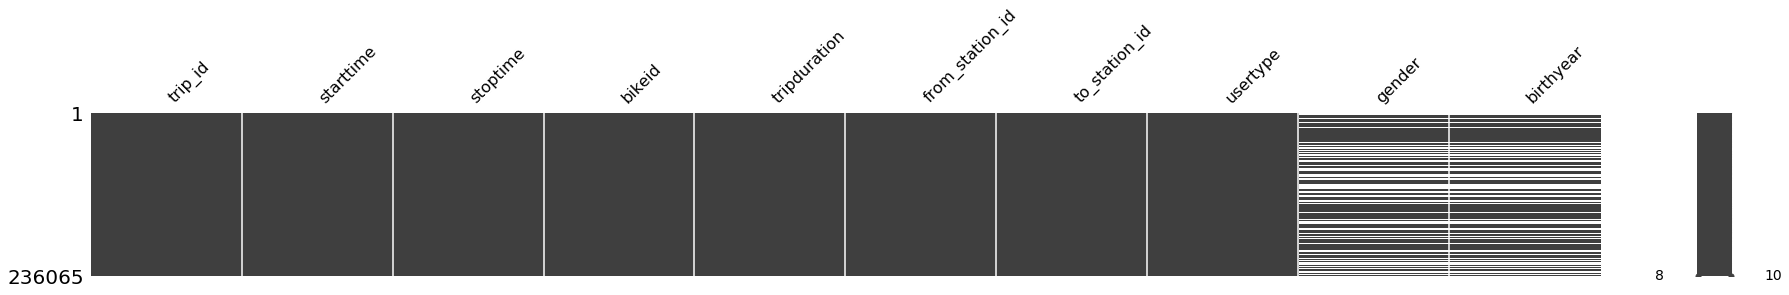

In [14]:
_ = msno.matrix(trip, figsize=(30,3))

We know that `usertype` has only two characteristics, a *casual user* and a *member*. And since usertype has no NAs we can check if every missing value is connceted to *casual user*. This is not the case. There are 4 data points of members that have no *birthyear* chacteristic.

In [15]:
(trip.loc[(trip['gender'].isna()) & (trip['usertype'] == 'Member')]['trip_id'].count(), 
 trip.loc[(trip['birthyear'].isna()) & (trip['usertype'] == 'Member')]['trip_id'].count())

(0, 4)

We treat these NAs in the same manner as before by setting the year to `1900`.

In [16]:
# changing datatype of birthyear to int64 and set NAs to 1900
trip['birthyear'] = trip['birthyear'].fillna(1900).astype(np.int64)

# filling NAs in gender to 'NA'
trip['gender'] = trip['gender'].fillna('NA')

When we now look at the summary from before, we see that we got rid of all missing values and on top of that already cast the data into fitting datatypes.

In [17]:
for table in [station, trip]: display(pdsm.DataFrameSummary(table).summary().T)

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,58,0,0%,unique
name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,58,0,0%,unique
lat,58,47.6248,0.0190658,47.5985,47.6132,47.6186,47.6277,47.6661,58,58,0,0%,numeric
long,58,-122.327,0.0149567,-122.355,-122.339,-122.328,-122.317,-122.284,58,58,0,0%,numeric
install_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,9,0,0%,date
install_dockcount,58,17.5862,3.06099,12,16,18,18,30,58,7,0,0%,numeric
modification_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,13,0,0%,date
current_dockcount,58,16.5172,5.11702,0,16,18,18,26,58,7,0,0%,numeric
decommission_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,5,0,0%,date


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
trip_id,236065,130060,72842.3,431,67746,130526,192900,255245,236065,236065,0,0%,numeric
starttime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,176216,0,0%,date
stoptime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,169285,0,0%,date
bikeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,493,0,0%,categorical
tripduration,236065,1202.61,2066.42,60.008,392.265,633.235,1145.02,28794.4,236065,218883,0,0%,numeric
from_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
to_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
usertype,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,2,0,0%,bool
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,4,0,0%,categorical
birthyear,236065,1949.46,39.6033,1900,1900,1971,1985,1999,236065,62,0,0%,numeric


## Second look at the Data and Observations

Informationwise, the *station table* is more of a look-up table, which is why we focus on *trips* for now. We keep in mind that the distance expressed via the location of each station might be a useful feature for the learning process. 

### Scattering Plots

We start with a *scatter plot* to get a feel for the distribution of our sample. On the diagonal we see the bar chart of the respective variable. The histogram for `trip_id` shows a nearly constant distribution since it is just generated consecutively. This wouldn't be the case if the bike sharing business would have been around fore several decades. Then possibly older `trip_id` would match to older users. In `tripduration` we see a strong emphasis on short trips. The last bar indicates that most of the members are younger. This would suggest a younger core demographic but given we focus on members. 

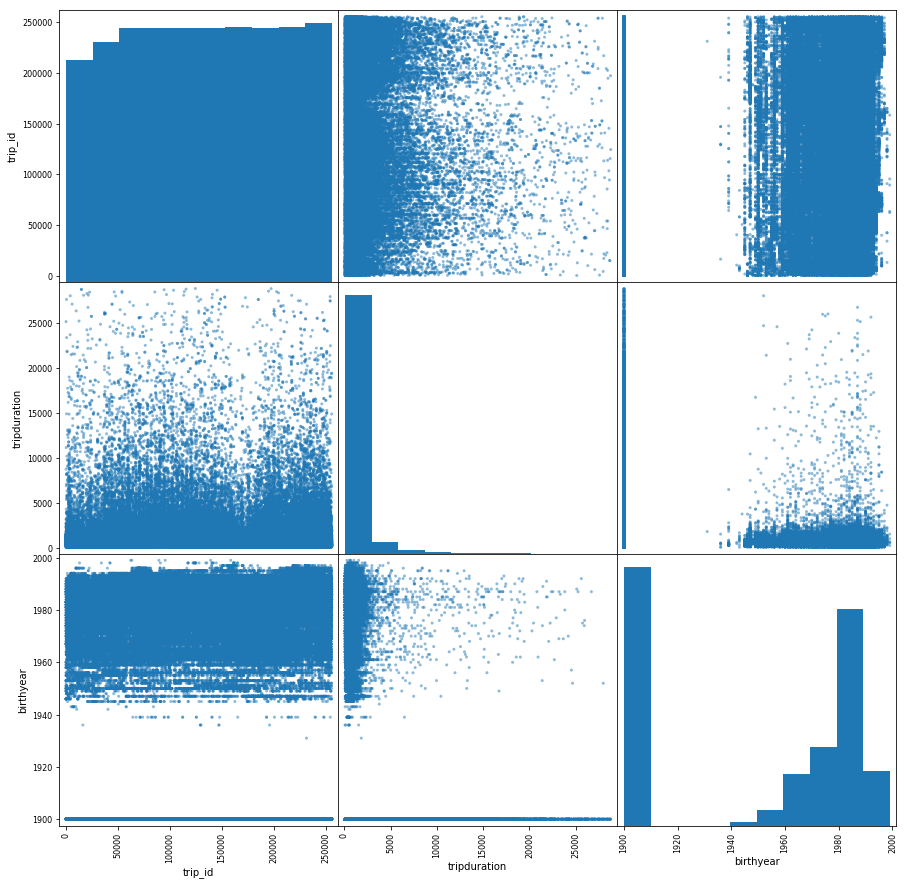

In [18]:
_ = pd.plotting.scatter_matrix(trip, figsize=(15,15))

When looking at tripduration over birthyear, we see quite a evenly spread distribution over the age. This can be deceptive, since one actually cannot see how many datapoints are on a close perimeter. A good way to remedy this are hex bin plots. Like the ones below. 

When looking at the one at the left at the bottom, which is related to the scatter plot I just mentioned, we see that actually more people in their mid 30s are using the sharing service. At least this is true when only considering members. Keep in mind, that we have `1900` as a dummy value. In the latter row I only looked at members to show the effect of our dummy value.

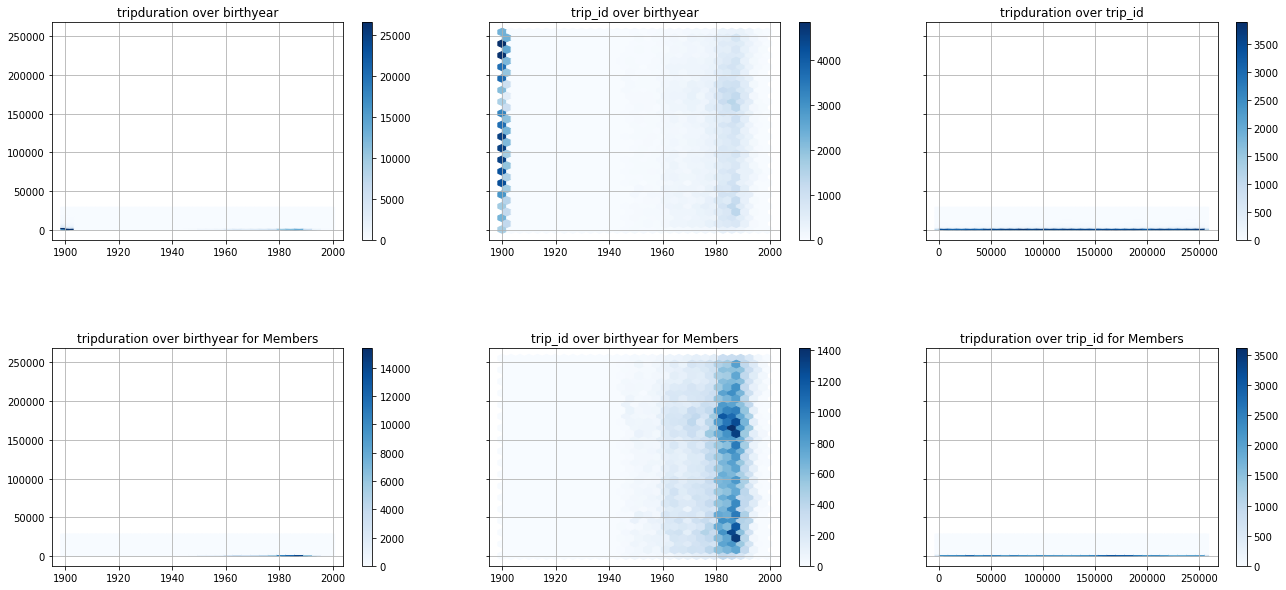

In [19]:
fig, axs = plt.subplots(nrows = 2, ncols=3, sharey=True, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0, 0]
ax.grid(True)
ax.set_title('tripduration over birthyear')
hb = ax.hexbin( trip['birthyear'].values, trip['tripduration'].values, gridsize=30, cmap='Blues')
cb = fig.colorbar(hb, ax=ax)
# cb.set_label('')

ax = axs[0, 1]
ax.grid(True)
ax.set_title('trip_id over birthyear')
hb = ax.hexbin( trip['birthyear'].values, trip['trip_id'].values, gridsize=30, cmap='Blues')
cb = fig.colorbar(hb, ax=ax)
# cb.set_label('')

ax = axs[0, 2]
ax.grid(True)
ax.set_title('tripduration over trip_id')
hb = ax.hexbin( trip['trip_id'].values, trip['tripduration'].values, gridsize=30, cmap='Blues')
cb = fig.colorbar(hb, ax=ax)
# cb.set_label('')

ax = axs[1, 0]
ax.grid(True)
ax.set_title('tripduration over birthyear for Members')
hb = ax.hexbin( trip.loc[trip['usertype'] == 'Member']['birthyear'].values, 
           trip.loc[trip['usertype'] == 'Member']['tripduration'].values, gridsize=30, cmap='Blues')
cb = fig.colorbar(hb, ax=ax)
# cb.set_label('')

ax = axs[1, 1]
ax.grid(True)
ax.set_title('trip_id over birthyear for Members')
hb = ax.hexbin(trip.loc[trip['usertype'] == 'Member']['birthyear'].values, 
           trip.loc[trip['usertype'] == 'Member']['trip_id'].values, gridsize=30, cmap='Blues')
cb = fig.colorbar(hb, ax=ax)
# cb.set_label('')

ax = axs[1, 2]
ax.grid(True)
ax.set_title('tripduration over trip_id for Members')
hb = ax.hexbin( trip.loc[trip['usertype'] == 'Member']['trip_id'].values, 
           trip.loc[trip['usertype'] == 'Member']['tripduration'].values, gridsize=30, cmap='Blues')
cb = fig.colorbar(hb, ax=ax)
# cb.set_label('')
plt.show()

In [20]:
# for saving progress
trip.to_pickle('tmp/trip.pickle')
station.to_pickle('tmp/station.pickle')

### Number of Trips to and from Specific Stations 

In [21]:
# loading the previous variables
trip = pd.read_pickle('tmp/trip.pickle')
station = pd.read_pickle('tmp/station.pickle')

In [22]:
pdsm.DataFrameSummary(trip).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
trip_id,236065,130060,72842.3,431,67746,130526,192900,255245,236065,236065,0,0%,numeric
starttime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,176216,0,0%,date
stoptime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,169285,0,0%,date
bikeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,493,0,0%,categorical
tripduration,236065,1202.61,2066.42,60.008,392.265,633.235,1145.02,28794.4,236065,218883,0,0%,numeric
from_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
to_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
usertype,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,2,0,0%,bool
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,4,0,0%,categorical
birthyear,236065,1949.46,39.6033,1900,1900,1971,1985,1999,236065,62,0,0%,numeric


I also wanted to know if there are for example some stations, that are more likely to be driven to than starting a bike ride from. 

I was suprised how uniformly these characteristics are distributed. In this case it would be interesting to have some data on individual users to see how many comuters are using this service. Do they travel both distances. Also it would be nice to know if some only travels in one direction. 

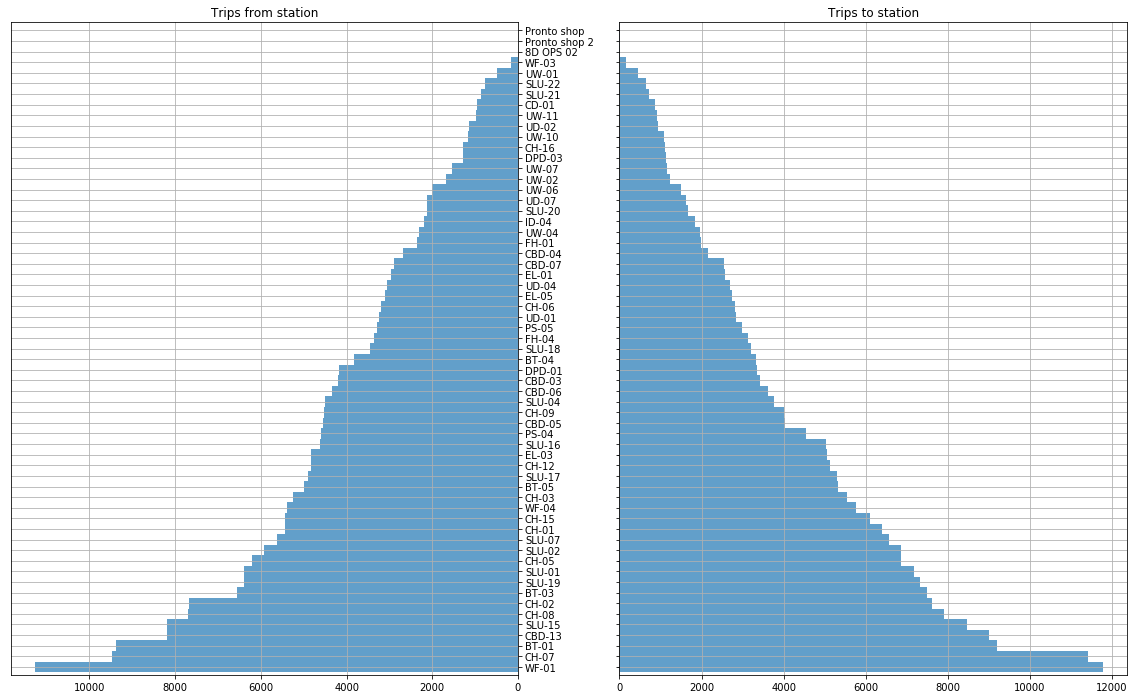

In [23]:
fig = plt.figure(figsize=(20,12))
fig.add_subplot(1,2,1)
ax = plt.gca()
ax.yaxis.tick_right()
ax.invert_xaxis()
trip['from_station_id'].value_counts().plot(kind='barh', rot=0, grid=True, alpha=0.7, width=1, sharey=True)
plt.title('Trips from station')
fig.add_subplot(1,2,2)
trip['to_station_id'].value_counts().plot(kind='barh', rot=0, grid=True, alpha=0.7, width=1, sharey=True)
plt.title('Trips to station')
plt.show()

To see the trips per hour and to get a feel on how much the service is used during a course of a day as well as a week, we need some additional features. 

### Feature Engineering

Most importantly we need a count for trips taken. The variable starttime is a good candidate. So we want to know how many trips in an hour started from each station at a specific date. Intuitively I think this is the finest scale we can look at. 

At first we add some additional features like `start_month`, `week`, `weekday`, `Date`, and `year` to our trip table. In order to get the number of trips taken each hour we group a part of our train table and copy it to a new Frame. I then rearranged both frames in the same way so that I can simply concatenate the Frames. I tried doing this with a merge, but the frames were so mismatched, that my machine crached several times. By doing this manually, we don't run into any problems alike.

In [24]:
trip.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,CBD-06,PS-04,Member,Male,1960
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,CBD-06,PS-04,Member,Male,1970
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,CBD-06,PS-04,Member,Female,1988
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,CBD-06,PS-04,Member,Female,1977
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,CBD-06,PS-04,Member,Male,1971


In [25]:
def generate_features(df):
    df['Date'] = df.starttime.dt.date
    df['Year'] = df.starttime.dt.year
    df['MonthOfYear'] = df.starttime.dt.month
    df['WeekOfYear'] = df.starttime.dt.week
    df['DayOfWeek'] = df.starttime.dt.day
    df['HourOfDay'] = df.starttime.dt.hour
    df.rename(columns={'from_station_id' : 'Station'}, inplace=True)

In [26]:
generate_features(trip)

In [27]:
# regroup new sliced DataFrame 
df = trip.groupby(['Station', 'Date', 'HourOfDay'], as_index=False)['trip_id'].count()
df = pd.DataFrame(df)

In [28]:
# rename some columns
df.rename(columns={'trip_id' : 'Trip_count'}, inplace=True)

In [29]:
# resort and reset the index to regain a regular DataFrame object
df = df.sort_values(['Date', 'HourOfDay', 'Station'])
df = df.reset_index(drop=True)

In [30]:
# do the same to the original DataFrame
trip = trip[['Station', 'Date', 'HourOfDay']].loc[
trip[['Station', 'Date', 'HourOfDay']].drop_duplicates().index]
trip = trip.sort_values(['Date', 'HourOfDay', 'Station'])
trip = trip.reset_index(drop=True)

In [31]:
# concatenate both frames and recast datetime datatype
trip = pd.concat([trip, df], axis=1, sort=False)
trip = trip.loc[:, ~trip.columns.duplicated()]
trip['Date'] = pd.to_datetime(trip['Date'])
trip['Year'] = trip.Date.dt.year
df1 = trip
trip.dtypes

Station               object
Date          datetime64[ns]
HourOfDay              int64
Trip_count             int64
Year                   int64
dtype: object

In [32]:
trip.head()

,Station,Date,HourOfDay,Trip_count,Year
0,CBD-06,2014-10-13,10,6,2014
1,CBD-05,2014-10-13,11,1,2014
2,CBD-07,2014-10-13,11,1,2014
3,CH-02,2014-10-13,11,3,2014
4,DPD-01,2014-10-13,11,1,2014


In the end I made sure that Date is still a datetime datatype. We can use `df1` to plot the absolute frequency of trips per hour:

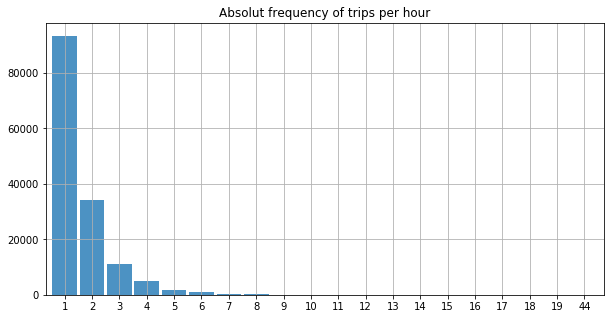

In [33]:
plt.figure(figsize=(10,5))
df1['Trip_count'].value_counts().plot(kind='bar', rot=0, grid=True, alpha=0.8, width=0.9)
plt.title('Absolut frequency of trips per hour')
plt.show()

We can see that most of the values are by far one or two trips in hour at any station. I will come back to this, because I think I dit not account for this correctly. 

I also want to look at the distribution over a week. Therefore, I created a new dataframe and added `DayOfWeek` to it. 

In [34]:
df = trip
df['DayOfWeek'] = df.Date.dt.weekday

In [35]:
df.head()

,Station,Date,HourOfDay,Trip_count,Year,DayOfWeek
0,CBD-06,2014-10-13,10,6,2014,0
1,CBD-05,2014-10-13,11,1,2014,0
2,CBD-07,2014-10-13,11,1,2014,0
3,CH-02,2014-10-13,11,3,2014,0
4,DPD-01,2014-10-13,11,1,2014,0


After droping two columns and rearranging the array, I summed all `Trip_counts` over every `Year` and `DayOfWeek`. The result is displayed below. Aside from the first year, there seems to be a tendency to to the middle of the week. 

In [36]:
df = df.drop(columns=['Date', 'HourOfDay'])

In [37]:
df.sort_values(['Station', 'Year', 'DayOfWeek'])
df = df.reset_index(drop=True)

In [38]:
A=np.zeros((7,3))
for i, a in enumerate(range(2014,2017)):
    for j, b in enumerate(range(0,7)):
        A[j,i] = df.loc[(df['Year'] == a) & (df['DayOfWeek'] == b)]['Trip_count'].sum()
    
df = pd.DataFrame(A)
df.columns=['2014', '2015', '2016']
df.index=['Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

<Figure size 1440x360 with 0 Axes>

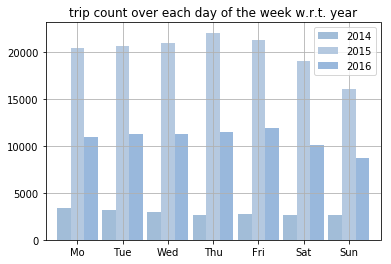

In [39]:
plt.figure(figsize=(20,5))
df.plot(kind='bar', rot=0, grid=True, alpha=0.9, width=0.9, color=['#98B6D4', '#ADC4DD', '#8EB1D9'])
plt.title('trip count over each day of the week w.r.t. year')
plt.show()

The following map shows an overview on the bike stations' location in Seattle.  The pink locations are the 4 stations that were decommissioned during the observation period.  

In [40]:
# Setting up an empty map
flm_map = folium.Map(location=[47.635, -122.31], zoom_start=12)

# choosing columns from station
data = station[['station_id', 'lat', 'long', 'decommission_date']]
# adding marker for stations positions in Seattle with ID as label
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lat'], data.iloc[i]['long']], popup=data.iloc[i]['station_id'], 
                  icon=folium.Icon(color=(lambda i :'pink' if data.iloc[i]['decommission_date'] != datetime(1900,1,1)
                                          else 'blue')(i))).add_to(flm_map)
# flm_map.save('flm_map.html')
flm_map

In [41]:
# save progress
trip.to_pickle('tmp/trip.pickle')

## Prediction Model

In [42]:
# load progress
trip = pd.read_pickle('tmp/trip.pickle')

The task is to predict the damnd of bikes at each of the stations, at any given date and time. My approach was to use a Neural Network with Entity Embeddings very similar to [Guo, Berkhahn - Entitiy Embeddings of Caterocal Veriables](https://arxiv.org/abs/1604.06737). The article explains how to use embeddings, which are very popular in recommender systems and especially NLP. The basic idea is to treat some values like days, year, etc. not as continuous variables but as categorical by embedding them into a vector space. 

The authors placed third in a kaggle competition on predicting the amount of sales on a given day and a given store. This is a very similar scenario and I was quite confident for it to work out. 

![Prediction Model: Neural Network with Entity Embedding](img/model.png)

The picture above shows the final model I chose. The main reason is that I was always strongly overfitting and nothing I tried was able to remedy the situation. Dropout, weight-decay, L1, L2 regularization, BatchNormaliation. I even ended up with only one neuron at a time. 

I think the problem lies in the distribution of the demand. We saw earlier, that most of the data points in this set show 1 rental at a specific day at a specific hour. Actually, if one were to predict 1 every time, he would get a accuracy of approximatey 65%. 

Also, when just looking at the days, we only have about 30k datapoints, which is also not a lot and might also account for the bad results.

I also tried setting this up as classifier using the amount of rented bikes per day at a station. I think one of the main problems with that is the following. When using a standard metric like euclidean distance, predicting one instead of two rentals is not that bad but when looking at a classification, the opposite is true. 

<img src="img/val.png" alt="Drawing" style="width: 400px;"/> 
<img src="img/acc.png" alt="Drawing" style="width: 400px;"/>

On the other hand, I was able to take a look at the resulting confusion matrix. This also indicates that most of the predictions are actually in the correct corner but the is just not enough information on the other classes. 

<img src="img/cm2.png" alt="Drawing" style="width: 600px;"/>

Overall, I had better results with the regression setting. 

Let us now prepare the data for the model. 

In [43]:
trip.head()

,Station,Date,HourOfDay,Trip_count,Year,DayOfWeek
0,CBD-06,2014-10-13,10,6,2014,0
1,CBD-05,2014-10-13,11,1,2014,0
2,CBD-07,2014-10-13,11,1,2014,0
3,CH-02,2014-10-13,11,3,2014,0
4,DPD-01,2014-10-13,11,1,2014,0


We take Year, DayOfWeek and Station as inputs and Trip_count as output.

In [44]:
train_data_X = trip[['Station', 'Year', 'DayOfWeek', ]]
train_data_y = trip[['Trip_count']]
train_data_X = train_data_X.apply(preprocessing.LabelEncoder().fit_transform)

# save to disk
train_data_X.to_pickle('tmp/train_data_X.pickle')
train_data_y.to_pickle('tmp/train_data_y.pickle')

As I mentioned, I set this up as a classifier, so the outputs have to be one encoded

In [45]:
# load data
X = pd.read_pickle('tmp/train_data_X.pickle').values
y = pd.read_pickle('tmp/train_data_y.pickle').values

In [46]:
y_OHE = np.zeros((X.shape[0], len(np.unique(y))))
y_OHE = preprocessing.OneHotEncoder(sparse=False).fit_transform(y)

/home/sg/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [47]:
# training, and validation split
train_ratio = 0.9
train_size = int(train_ratio * len(X))

X_train = X[:train_size]
X_val = X[train_size:]
y_train = y_OHE[:train_size, :]
y_val = y_OHE[train_size:, :]

Via importing the functions from train_and_test, the model and thereforce the constructor gets called. 

In [48]:
from train_and_test import *

/home/sg/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
station (Embedding)             (None, 1, 10)        610         input_1[0][0]                    
__________________________________________________________________________________________________
year (Embe

Epoch 20/100
132481/132481 [==============================] - 4s 33us/step - loss: 1.0368 - acc: 0.6402 - val_loss: 1.1336 - val_acc: 0.5813

Epoch 00020: val_loss did not improve from 1.13074
Epoch 21/100
132481/132481 [==============================] - 5s 35us/step - loss: 1.0368 - acc: 0.6402 - val_loss: 1.1327 - val_acc: 0.5813

Epoch 00021: val_loss did not improve from 1.13074
Epoch 22/100
132481/132481 [==============================] - 4s 33us/step - loss: 1.0366 - acc: 0.6402 - val_loss: 1.1312 - val_acc: 0.5813

Epoch 00022: val_loss did not improve from 1.13074
Epoch 23/100
 96000/132481 [====================>.........] - ETA: 1s - loss: 1.0388 - acc: 0.6396

KeyboardInterrupt: 